## Imputation

### Step 1. Load the data

In [82]:
import csv 
import numpy as np

with open('covid_randomrowsa.csv', 'rt') as file:
    reader = csv.reader(file)
    data = list(reader)

# the first row is the feature names
print("There are in total of ", len(data) - 1, " tuples.");

There are in total of  4600  tuples.


### Step 2. Data Investigation

Something need to know before preceeding. The questionnaire contains a series of questions. I will list the question category, the number of questions of that category, the column index in the data file below.

| Category Name | Number of Questions | Column Indices |
|---------------|---------------------|----------------|
|Physical Contact| 5 | 7 - 11 |
|Physical Hygiene| 5 | 12 - 16 |
|Anti-corona Policy Support| 5 | 17 - 21 | 
|Generosity| 4 | 22 - 25 |
|Psychological Well-being| 2 | 26 - 27 |
|Collective Narcissism| 3 | 28 - 30 |
|National Identification| 2 | 31 - 32 |
|Comspiracy Thoeries| 4 | 33 - 36 | 
|Open-mindedness| 6 | 37 - 42 | 
|Morality as Cooperation| 7 | 43 - 49 | 
|Trait Optimism| 2 | 50 - 51 | 
|Social Belonging| 4 | 52 - 55 | 
|Trait Self-control| 4 | 56 - 59 | 
|Self-esteem| 1 | 60 |
|Narcissism| 6 | 61 - 66 | 
|Moral Identity| 10 | 67 - 76 |
|Risk Perception| 2 | 77 - 78 |
|Political Ideology| 1 | 79 | 
|Moral Circle| 1 | 80 | 
|Pysical Health| 1 | 81 | 
|Cognitive Reflection Test| 3 | 82 - 84 |
|Sex| 2 | 85 - 86 | 
|Age| 1 | 87 |
|Marital Status| 1 | 88 |
|Number of Children| 1 | 89 | 
|Employment Status| 2 | 90 - 91 |
|Ladder| 1 | 92 | 
|Urban?| 1 | 93 |
|Tested Positive| 1 | 94 |
|Known Tested Positive| 1 | 95 |


Notice:
- We will drop column for sex other input, as the sex column contains the other option.
- We will drop column for employment status for the same reason.
- We will drop column for Urban as there is no such information in the questionnaire at all.

### Step 3: Missing Data Analysis 

<AxesSubplot:>

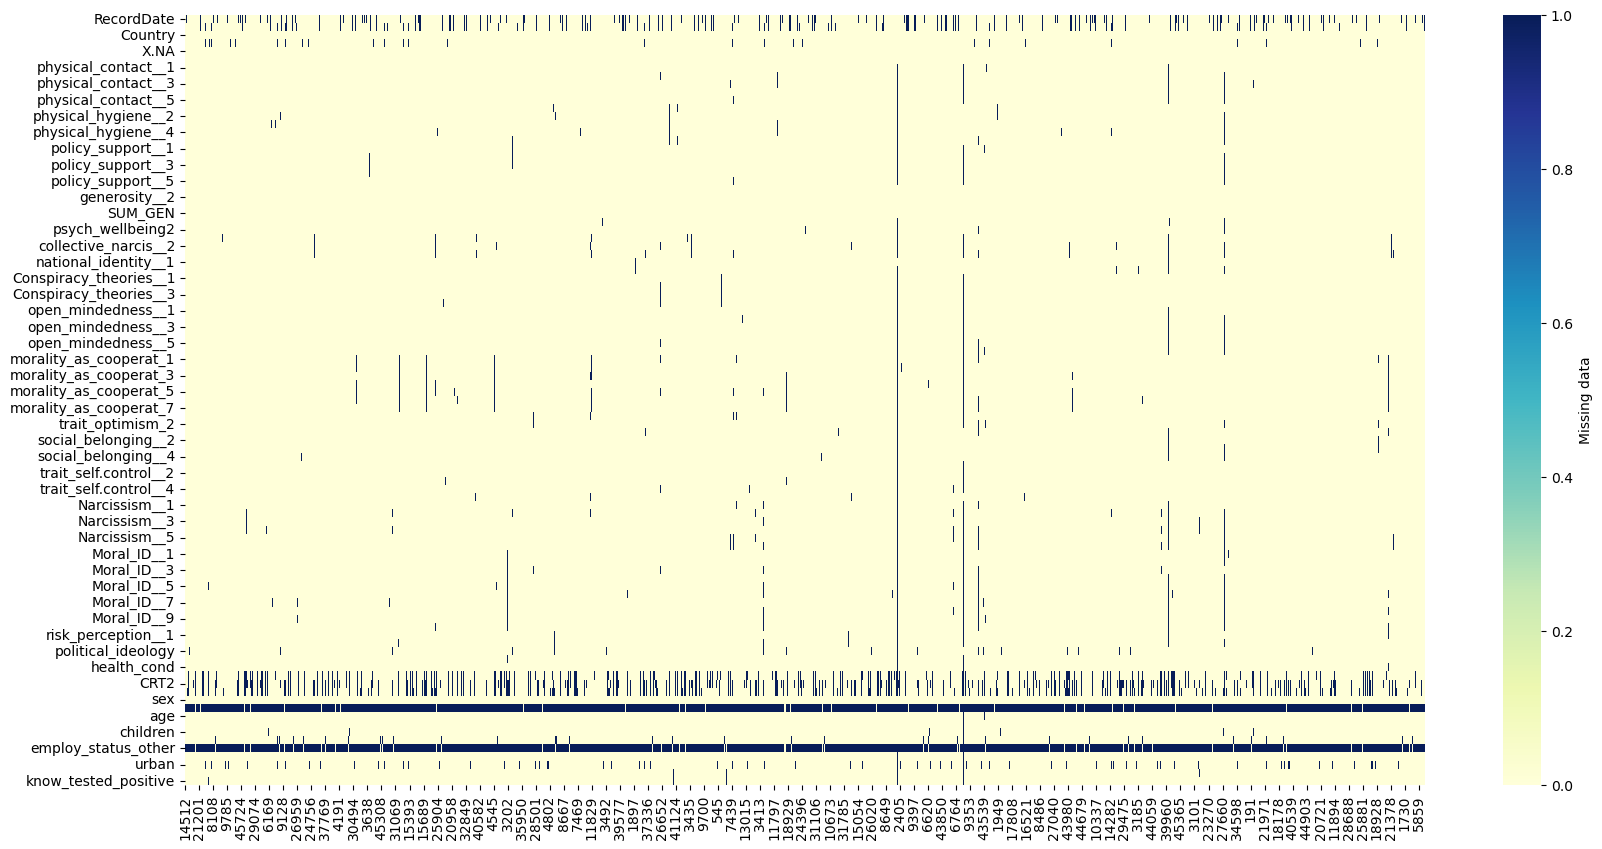

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

a = pd.read_csv('covid_randomrowsa.csv', index_col=0)

plt.figure(figsize = (20,10))
sns.heatmap(a.isna().transpose(),
           cmap="YlGnBu",
           cbar_kws={'label': 'Missing data'})


#### Analysis
We can see that from the plot above, missing data is distributed mainly in questions for sex other input and employment status other input. We have also found a large proportion of missing data for Cognitive Reflection Test (CRT) section. The rationale behind this might be that this section requires text inputs from users and this section resides in the middel to ending part of the whole questionnaire thus most users chose to skip these questions.

#### Decision
- We would like to include the country column into the data set and remove the tuples with None for country.
- We would like to remove the CRT section (3 questions - 3 columns) as there is no meaning of computing the mean values given the large number of missing values.

### Step 4: Dealing with Categorical data - Country

In [84]:
import pandas as pd

country_data = [d[3] for d in data[1:]]
country_dummy = pd.get_dummies(country_data)
data_categorical = data.copy()
for i in range(1, len(data)):
    data_categorical[i][3] = list(country_dummy.values[i-1]).index(1)
#     print(len(data_categorical[i][3]))



### Step 5: Imputation

The mean value of the answers within the same catogory will be chosen for `NA` answer. If there is only one question within that category with an answer NA, that tuple will be dropped.

In [85]:
def average(piece, s, e):
    total = 0
    number = 0
#     if s == 3:
#         for i in piece[s]:
#             number += i
#         if number == 0:
#             return -1
#         else:
#             return
    
    for i in range(s, e):
        if piece[i] == 'NA' or piece[i] == '':
            continue
        else:
            total += float(piece[i])
            number += 1
    if number == 0:
        return -1
    else:
        return total/number

def process(data):
    # set of indexes of tuples to be deleted
    to_delete = set()
    
    for i in range(1, len(data)):
        # processing one tuple

        # pysical contact
        for pair in [[3,3],[7,11], [12,16], [17,21], [22,25], [26, 27], [28, 30], [31, 32], [33,36], [37,42], [43, 49], [50,51], [52, 55], [56, 59], [60, 60], [61, 66], [67, 76], [77, 78], [79, 79], [80, 80], [81, 81], [82, 84], [85, 85], [87, 87], [88, 88], [89, 89], [90, 90], [92, 92], [94, 94], [95, 95]]:
            for j in range(pair[0], pair[1] + 1):
                if data[i][j] == 'NA' or data[i][j] == '':
                    if average(data[i], pair[0], pair[1] + 1) == -1:
                        to_delete.add(i)
                        break
                    else:
                        data[i][j] = average(data[i], pair[0], pair[1] + 1)
                else:
                    if j != 3:
                        # the country column is text input
                        data[i][j] = float(data[i][j])
                
    return to_delete


# imputation and record the number of tuples to be deleted
imputation_data = data_categorical.copy()
to_delete = process(imputation_data)
print("There are ", len(to_delete), " out of ", len(data) - 1, " pieces of data to be deleted.")

There are  778  out of  4600  pieces of data to be deleted.


### Step 6: Trim off unnecessary columns and data cleaning
Some columns will be deleted as they contribute nothing to the discovery such as record id.

In [86]:
data_to_use = []
for i in range(0, len(imputation_data)):
    if i in to_delete:
        continue
    else:
        data_to_use.append(imputation_data[i])

print(len(data_to_use))
print(len(data_to_use[0]))

3823
96


In [87]:
to_delete_column = [0, 1, 2, 4, 5, 6, 82, 83, 84, 86, 91, 93]
data_final = []
for piece in data_to_use:
    new_piece = []
    for i in range(0, len(piece)):
        if i in to_delete_column:
            continue;
        else:
            new_piece.append(piece[i])
    data_final.append(new_piece)
print(len(data_final))
print(len(data_final[0]))


3823
84


## Models

### Model 1: SVM

In [88]:
data_data = [d[:-2] for d in data_final][1:]
target_positive = [d[-2] for d in data_final][1:]
target_known_positive = [d[-1] for d in data_final][1:]

In [89]:
from sklearn.model_selection import train_test_split

# 80% training 20% testing 
X_train, X_test, y_train, y_test = train_test_split(data_data, target_positive, test_size=0.2,random_state=109) 

In [94]:
from sklearn import svm
import time

start_time = time.time()
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
print("Training for SVM used ", time.time() - start_time, " seconds.")

y_pred = clf.predict(X_test)

Training for SVM used  118.20885300636292  seconds.


In [95]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9686274509803922


In [96]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [97]:
from tabulate import tabulate

def print_importances_table(coef, names):
    yx = list(zip(clf.coef_[0], names))
    yx.sort()
    yx.reverse()
    print(tabulate(yx, headers=["Coef", "Name"]))
    
names = [d[:-2] for d in data_final][0]
print_importances_table(clf.coef_, names)

        Coef  Name
------------  ----------------------
 0.000629549  Moral_ID__10
 0.000499528  Narcissism__3
 0.000469093  social_belonging__4
 0.000459712  morality_as_cooperat_5
 0.000451487  open_mindedness__2
 0.000428897  collective_narcis__3
 0.000359644  physical_contact__2
 0.000354122  open_mindedness__3
 0.000329608  Conspiracy_theories__4
 0.000294782  physical_hygiene__3
 0.000293441  marit_status
 0.000285435  physical_hygiene__2
 0.00026738   Narcissism__4
 0.000265811  Moral_ID__2
 0.000256445  Moral_ID__7
 0.000214934  Narcissism__6
 0.00019276   trait_self.control__3
 0.000164835  physical_contact__5
 0.000161544  trait_optimism_1
 0.00014303   health_cond
 0.000141372  psych_wellbeing1
 0.000141093  physical_contact__1
 0.000139453  policy_support__1
 0.000139322  Conspiracy_theories__3
 0.000135164  open_mindedness__1
 0.000104616  policy_support__3
 0.00010263   Moral_ID__9
 9.20577e-05  Moral_ID__5
 9.12478e-05  social_belonging__2
 8.13454e-05  physical_hygiene_

### Model 2: Logistic Regression

In [98]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg.fit(X_train, y_train)
y_pred2 = logreg.predict(X_test)

In [99]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Accuracy: 0.9673202614379085


In [100]:
print_importances_table(logreg.coef_, names)

        Coef  Name
------------  ----------------------
 0.000629549  Moral_ID__10
 0.000499528  Narcissism__3
 0.000469093  social_belonging__4
 0.000459712  morality_as_cooperat_5
 0.000451487  open_mindedness__2
 0.000428897  collective_narcis__3
 0.000359644  physical_contact__2
 0.000354122  open_mindedness__3
 0.000329608  Conspiracy_theories__4
 0.000294782  physical_hygiene__3
 0.000293441  marit_status
 0.000285435  physical_hygiene__2
 0.00026738   Narcissism__4
 0.000265811  Moral_ID__2
 0.000256445  Moral_ID__7
 0.000214934  Narcissism__6
 0.00019276   trait_self.control__3
 0.000164835  physical_contact__5
 0.000161544  trait_optimism_1
 0.00014303   health_cond
 0.000141372  psych_wellbeing1
 0.000141093  physical_contact__1
 0.000139453  policy_support__1
 0.000139322  Conspiracy_theories__3
 0.000135164  open_mindedness__1
 0.000104616  policy_support__3
 0.00010263   Moral_ID__9
 9.20577e-05  Moral_ID__5
 9.12478e-05  social_belonging__2
 8.13454e-05  physical_hygiene_